## Setup

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys

sys.path.append('../../')
from codebase.models.model3v2 import model3pro
from codebase.train import train, dataset_token, custom_collate, plot_losses, tokenizer, train_steps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.9)

Usando dispositivo: cuda


In [6]:
# cargamos los datos 100k
data = pd.read_csv('../../data/es-es_LF_100k.txt', sep='\t', header=None, on_bad_lines='skip')
filtered_vocab = np.load('../../data/sub_vocab.npy').tolist()
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,las compañías que los venden afirman que son u...,los vivos que los largan aseguran que son un m...
1,academias y escuelas en quart de poblet página...,los colegios y las escuelas en quart de poblet...
2,existen varias áreas recreativas como la del m...,"hay varios chongos para reventar la tarde, com..."
3,moldeo por inyección de plástico,meterle el plástico a presión
4,"el equipo descendió a segunda división, quedan...","el cuadro se fue al tacho a la b, quedando emp..."


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['spanish'], data['lunfardo'],
                                                  test_size=0.05, random_state=28)

train_dataset = dataset_token(X_train, y_train)
val_dataset = dataset_token(X_val, y_val)

print('Primer elemento del dataset de validación:', val_dataset[3])

Primer elemento del dataset de validación: {'input': tensor([  101, 18470, 11246, 10126, 10153, 13653, 12867, 29637, 10126, 10305,
        11129, 10102, 11499, 89348, 10117, 16901,   119,   102],
       device='cuda:0'), 'target': tensor([  101, 10525, 28083, 10126, 10153, 10106, 24847, 29637, 10126, 17322,
        17368, 10102, 11499, 89348, 10106, 25930,   119,   102],
       device='cuda:0'), 'input_length': tensor(18, device='cuda:0'), 'target_length': tensor(18, device='cuda:0')}


In [8]:
def generate_target(model, dataset, IDX):
    input_IDX = dataset[IDX]['input']
    target_IDX = dataset[IDX]['target']
    target_pred_IDX = model.generate(input_IDX)
    print(tokenizer.decode(input_IDX))
    print(tokenizer.decode(target_IDX))
    print(tokenizer.decode(target_pred_IDX))

## Configuration 1
Tiene que poder memorizar 10 muestras para empezar

In [16]:
# Inicializa el modelo 
model = model3pro(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512//2,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 8297745 parámetros


In [17]:
BATCH_SIZE = 5
MAX_STEPS = 2000
LR = 1e-4

data_overfit = data.head(BATCH_SIZE)
dataset_overfit = dataset_token(data_overfit['spanish'], data_overfit['lunfardo'])
loader_overfit = DataLoader(dataset_overfit, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train_steps(model, loader_overfit, max_steps=MAX_STEPS, lr=LR, verbose_each=5)

Iniciando entrenamiento...
--------------------------------------------------
Entrenamiento completado! Tiempo total: 1.15 minutos


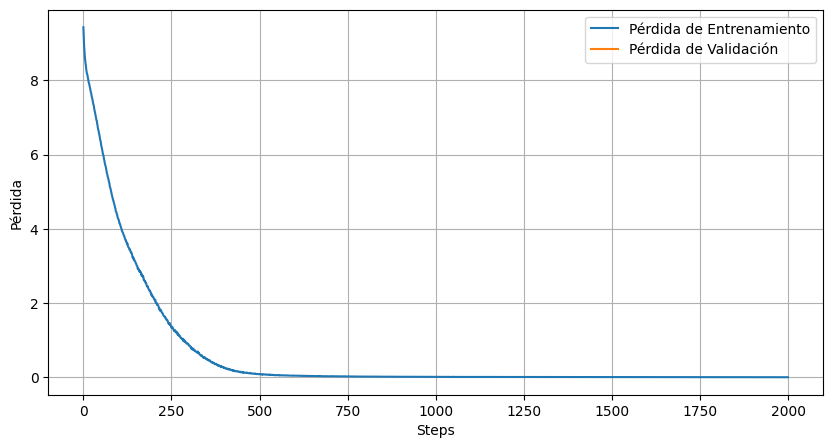

In [18]:
plot_losses(train_loss, val_loss, xlabel='Steps')

In [20]:
generate_target(model, dataset_overfit, IDX=0)

[CLS] las companias que los venden afirman que son un bien para la salud porque sus compuestos se presentan en concentraciones muy inferiores respecto a los tradicionales. [SEP]
[CLS] los vivos que los largan aseguran que son un milagro pa'la salud porque sus menjunjes andan en dosis de cagada, pero recontra menos que los de siempre. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]


In [21]:
generate_target(model, dataset_overfit, IDX=1)

[CLS] academias y escuelas en quart de poblet pagina quart de poblet. [SEP]
[CLS] los colegios y las escuelas en quart de poblet, la data de quart de poblet. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]


In [22]:
generate_target(model, dataset_overfit, IDX=2)

[CLS] existen varias areas recreativas como la del molino de pedroso que cuenta tambien con camping, la de la picota, en el coto y la presa del rey en jubia. existe tambien un parque urbano a orillas del rio freixeiro, junto al que se ha construido una de las mas grandes urbanizaciones de la comarca. naron cuenta con dos centros comerciales. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tam

In [23]:
generate_target(model, dataset_overfit, IDX=3)

[CLS] moldeo por inyeccion de plastico [SEP]
[CLS] meterle el plastico a presion [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]


In [24]:
generate_target(model, dataset_overfit, IDX=4)

[CLS] el equipo descendio a segunda division, quedando inmerso en una grave crisis economica agudizada por la obligatoriedad de tener que convertirse el club en sociedad anonima deportiva, lo que hizo que descendiera, al ano siguiente, directamente hasta la tercera division. [SEP]
[CLS] el cuadro se fue al tacho a la b, quedando empantanado en un quilombo de guita que se puso peor porque obligaron al club a hacerse sad, y eso hizo que al ano siguiente se pegara otro tortazo directo a la c. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]


## Configuration 2
Tiene que poder memorizar 5 muestras para empezar

In [9]:
# Inicializa el modelo 
model = model3pro(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512//2,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 8297745 parámetros


In [ ]:
BATCH_SIZE = 5
MAX_STEPS = 4000
LR = 1e-4

data_overfit = data.head(BATCH_SIZE)
dataset_overfit = dataset_token(data_overfit['spanish'], data_overfit['lunfardo'])
loader_overfit = DataLoader(dataset_overfit, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train_steps(model, loader_overfit, max_steps=MAX_STEPS, lr=LR, verbose_each=5)

Iniciando entrenamiento...
--------------------------------------------------
Entrenamiento completado! Tiempo total: 0.58 minutos


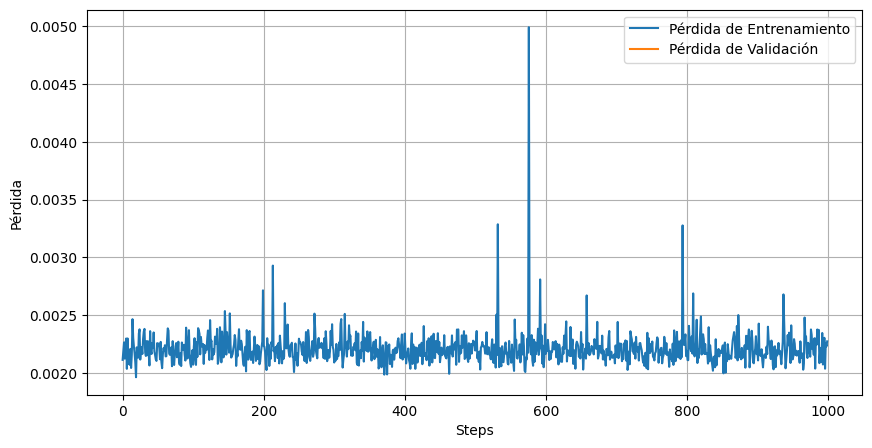

In [19]:
plot_losses(train_loss, val_loss, xlabel='Steps')

In [20]:
generate_target(model, dataset_overfit, IDX=0)

[CLS] las companias que los venden afirman que son un bien para la salud porque sus compuestos se presentan en concentraciones muy inferiores respecto a los tradicionales. [SEP]
[CLS] los vivos que los largan aseguran que son un milagro pa'la salud porque sus menjunjes andan en dosis de cagada, pero recontra menos que los de siempre. [SEP]
[CLS] los vivos que chong para revenn as tarde, como el del delino del viejo pedorro, que aparte quen que dosisar como unos pobres diablos.ra menos que los de siempre que que que en siguiente se coto, y represa del manda del mandamas en jubia tambien hay un parque piola ala del rio frei dexeiro, al lado de donde se clavaron unas de las urbanizaciones grosas deas de comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]


In [21]:
generate_target(model, dataset_overfit, IDX=1)

[CLS] academias y escuelas en quart de poblet pagina quart de poblet. [SEP]
[CLS] los colegios y las escuelas en quart de poblet, la data de quart de poblet. [SEP]
[CLS] los vivos que chong largan asegu que son como del del delino del viejo pedorro, que aparte que que ac quear como unos de diablos. menos que los de de de picota, ahi en cot de coto, y represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, lado de lado de clavaron unas de de de urbanizaciones mas grosas de comarca de en en naron, para colmo, te en enaron dos shoppings en [SEP]


In [22]:
generate_target(model, dataset_overfit, IDX=2)

[CLS] existen varias areas recreativas como la del molino de pedroso que cuenta tambien con camping, la de la picota, en el coto y la presa del rey en jubia. existe tambien un parque urbano a orillas del rio freixeiro, junto al que se ha construido una de las mas grandes urbanizaciones de la comarca. naron cuenta con dos centros comerciales. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tam

In [23]:
generate_target(model, dataset_overfit, IDX=3)

[CLS] moldeo por inyeccion de plastico [SEP]
[CLS] meterle el plastico a presion [SEP]
[CLS] los vivos que los que escuelas en un tarde, como del del molino del viejo pedorro que aparte que andan enampar como unos pobres diablos. menos que los de y de picota, ahi en coto, y y rep represa del mandamas en jubia. tambien hay un un parque piola a la rio rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]


In [24]:
generate_target(model, dataset_overfit, IDX=4)

[CLS] el equipo descendio a segunda division, quedando inmerso en una grave crisis economica agudizada por la obligatoriedad de tener que convertirse el club en sociedad anonima deportiva, lo que hizo que descendiera, al ano siguiente, directamente hasta la tercera division. [SEP]
[CLS] el cuadro se fue al tacho a la b, quedando empantanado en un quilombo de guita que se puso peor porque obligaron al club a hacerse sad, y eso hizo que al ano siguiente se pegara otro tortazo directo a la c. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca en naron, para colmo, te encajaronaron dos shoppings. [SEP]
